In [1]:

import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import torch

from copy import deepcopy
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
from typing import Tuple, Optional, List
from tqdm import tqdm


# Torch imports
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision

from PIL import Image
from torch import nn
from torchvision import transforms
from torchvision.datasets.folder import default_loader as loader 

# labml imports
from labml import lab, tracker, experiment, monit
from labml.configs import BaseConfigs, option
from labml_helpers.device import DeviceConfigs
from labml_nn.diffusion.ddpm import DenoiseDiffusion
from labml_nn.diffusion.ddpm.unet import UNet
# from labml_nn.diffusion.ddpm.experiment import Configs
from labml_nn.diffusion.ddpm.utils import gather

# Diffusion for Dynamics Model
This notebook is for using diffusion models to sample the next state in each step
Main steps will be as follows: 
1. Train a `eps_model` to predict the noise in the diffusion model
2. Also there will be an `MSE` loss between the generated position and the next position

## Model Implementations

In [30]:
class EpsModel(nn.Module): # It will get 2 values for position and 1 binary flag to indicate if the input is a dog or a box
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, output_shape) # Output shape will be two values (x and y)
        )

    def forward(self, x, t, a): # x: data, t: timestep of diffusion, a: action
        # Add another dimension to t
        t = t.reshape(x.shape) # They technically should have the same shape - noise timestepi
        a = a.reshape(x.shape) # For some reason the inputs have 1 dimension without reshape
        out = torch.cat((x,t,a), dim=-1)
        return self.model(out)

# Optimizer will be used to train this model

In [69]:
class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps # Number of steps to noise and denoise the data
        self.sigma2 = self.beta

    def gather(self, consts: torch.Tensor, t: torch.Tensor):
        c = consts.gather(-1, t)
        return c.reshape(-1, 1)

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean = self.gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - self.gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        if eps is None:
            eps = torch.randn_like(x0)
        mean, var = self.q_xt_x0(x0, t)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor, a: torch.Tensor):
        eps_theta = self.eps_model(xt, t, a)
        alpha_bar = self.gather(self.alpha_bar, t)
        alpha = self.gather(self.alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = self.gather(self.sigma2, t)

        eps = torch.randn(xt.shape, device=xt.device)
        # Torch clamp is necessary in order not to have a super small std
        return mean + torch.clamp((var ** .5) * eps, min=0.1)
        # return mean + (var ** .5) * eps

    def loss(self, x0: torch.Tensor, a: torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

        if noise is None:
            noise = torch.randn_like(x0)

        xt = self.q_sample(x0, t, eps=noise) # t times noised version for random different ts
        eps_theta = self.eps_model(xt, t, a) # It will still learn how to clean the noise with a guidance since the action is not being noised
        return F.mse_loss(noise, eps_theta)

    def next_state_loss(self, x0: torch.Tensor, xnext0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

        if noise is None:
            noise = torch.randn_like(x0)

        xt = self.q_sample(x0, t, eps=noise) # Noised x0
        eps_theta = self.eps_model(xt, t)
        diff_loss = F.mse_loss(noise, eps_theta)

        gen_x0 = torch.randn((batch_size, 1), device=x0.device)
        for t_ in range(self.n_steps):
            t = self.n_steps - t_ - 1
            gen_x0 = self.p_sample(gen_x0, gen_x0.new_full((batch_size,), t, dtype=torch.long)) # In the end gen_x0 should be newly generated latent
        
        mse_loss = F.mse_loss(gen_x0, xnext0) 

        return diff_loss, mse_loss

        
        

## Diffusion with Mock Data
We will do these things with the mock data first

### Mock Data Creation
There will be mock first and next data.


They will be two gaussian distributions with two different means

In [70]:
# Method to plot gaussian distribution with the given data
# It will first find the mean and std of the given data
# then it will plot it
def plot_gaus_dist(x, ax, label):
    traj_len = len(x)

    mean = x.mean()
    std = x.std()

    lin_range = np.linspace(mean-std*2, mean+std*2, traj_len)
    ax.plot(lin_range, stats.norm.pdf(lin_range, mean, std), label=label)
    ax.legend()

def plot_data(x, ax, label):
    traj_len = len(x)
    ax.plot(x, np.random.rand(traj_len), 'o', label=label)
    ax.legend()


In [71]:
class MockDist(data.Dataset):
    def __init__(self, curr_mean, curr_std, act_mean, act_std, dataset_size):
        # self.curr_mean = curr_mean 
        # self.curr_std = curr_std 
        # self.next_mean = next_mean 
        # self.next_std = next_std 
        self.dataset_size = dataset_size
        self.curr_data = np.random.normal(curr_mean, curr_std, dataset_size)
        self.action_data = np.random.normal(act_mean, act_std, dataset_size)
        random_noise = np.random.normal(0, 0.1, dataset_size)
        self.next_data = self.curr_data + self.action_data + random_noise
        # self.next_data = np.random.normal(next_mean, next_std, dataset_size)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, index):
        return torch.FloatTensor([self.curr_data[index]]), torch.FloatTensor([self.next_data[index]]), torch.FloatTensor([self.action_data[index]])

    def sample(self, is_curr, sample_size):
        if is_curr:
            return np.random.choice(self.curr_data, size=sample_size)
        else:
            return np.random.choice(self.next_data, size=sample_size)

In [72]:
action_mean, action_std = 6, 1.5
mock_dset = MockDist(
    curr_mean=1, curr_std=1,
    act_mean=action_mean, act_std=action_std,
    dataset_size=10000
)

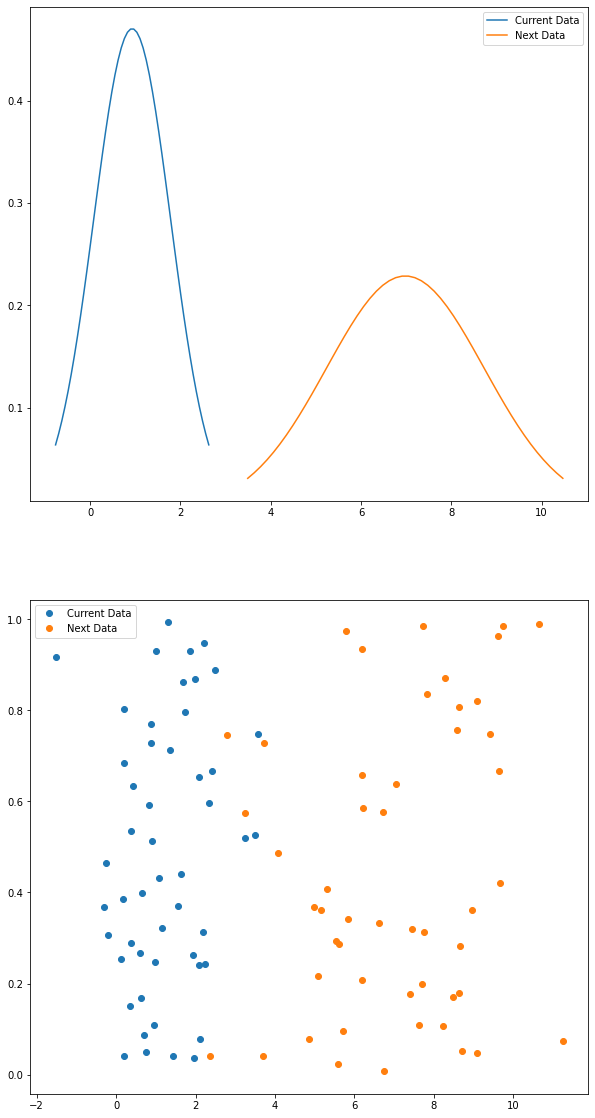

In [73]:
nrows = 2
ncols = 1
fig, axs = plt.subplots(figsize=(10*ncols, 10*nrows), ncols=ncols, nrows=nrows)
plot_gaus_dist(mock_dset.sample(True, 50), axs[0], label='Current Data')
plot_gaus_dist(mock_dset.sample(False, 50), axs[0], label='Next Data') 
plot_data(mock_dset.sample(True, 50), axs[1], label='Current Data')
plot_data(mock_dset.sample(False, 50), axs[1], label='Next Data') 

### Use Diffusion Model to Generate one of the Distributions
First step is to generate one of the distributions (let's say `curr_z` only for now)

In [74]:
# Initialize the models
device = torch.device('cuda:0')
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 60
N_SAMPLES = 100 # Number of values to sample when we sample from diffusion
N_STEPS = 50
eps_model = EpsModel(3,16,1).to(device) # Input shape: 1 for number 1 for timestep of the noise
diffusion = DenoiseDiffusion(
    eps_model=eps_model,
    n_steps=N_STEPS, # Number of steps to noise the data
    device=device # This model should be able to be trained on CPU
)
optimizer = torch.optim.Adam(params=eps_model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=WEIGHT_DECAY)


In [75]:
# Initialize the dataset and the dataloader
dataloader = data.DataLoader(mock_dset, batch_size=32, shuffle=True, num_workers=4)

Epoch: 59, Loss: 0.026490121790766714: 100%|██████████| 60/60 [00:53<00:00,  1.11it/s]


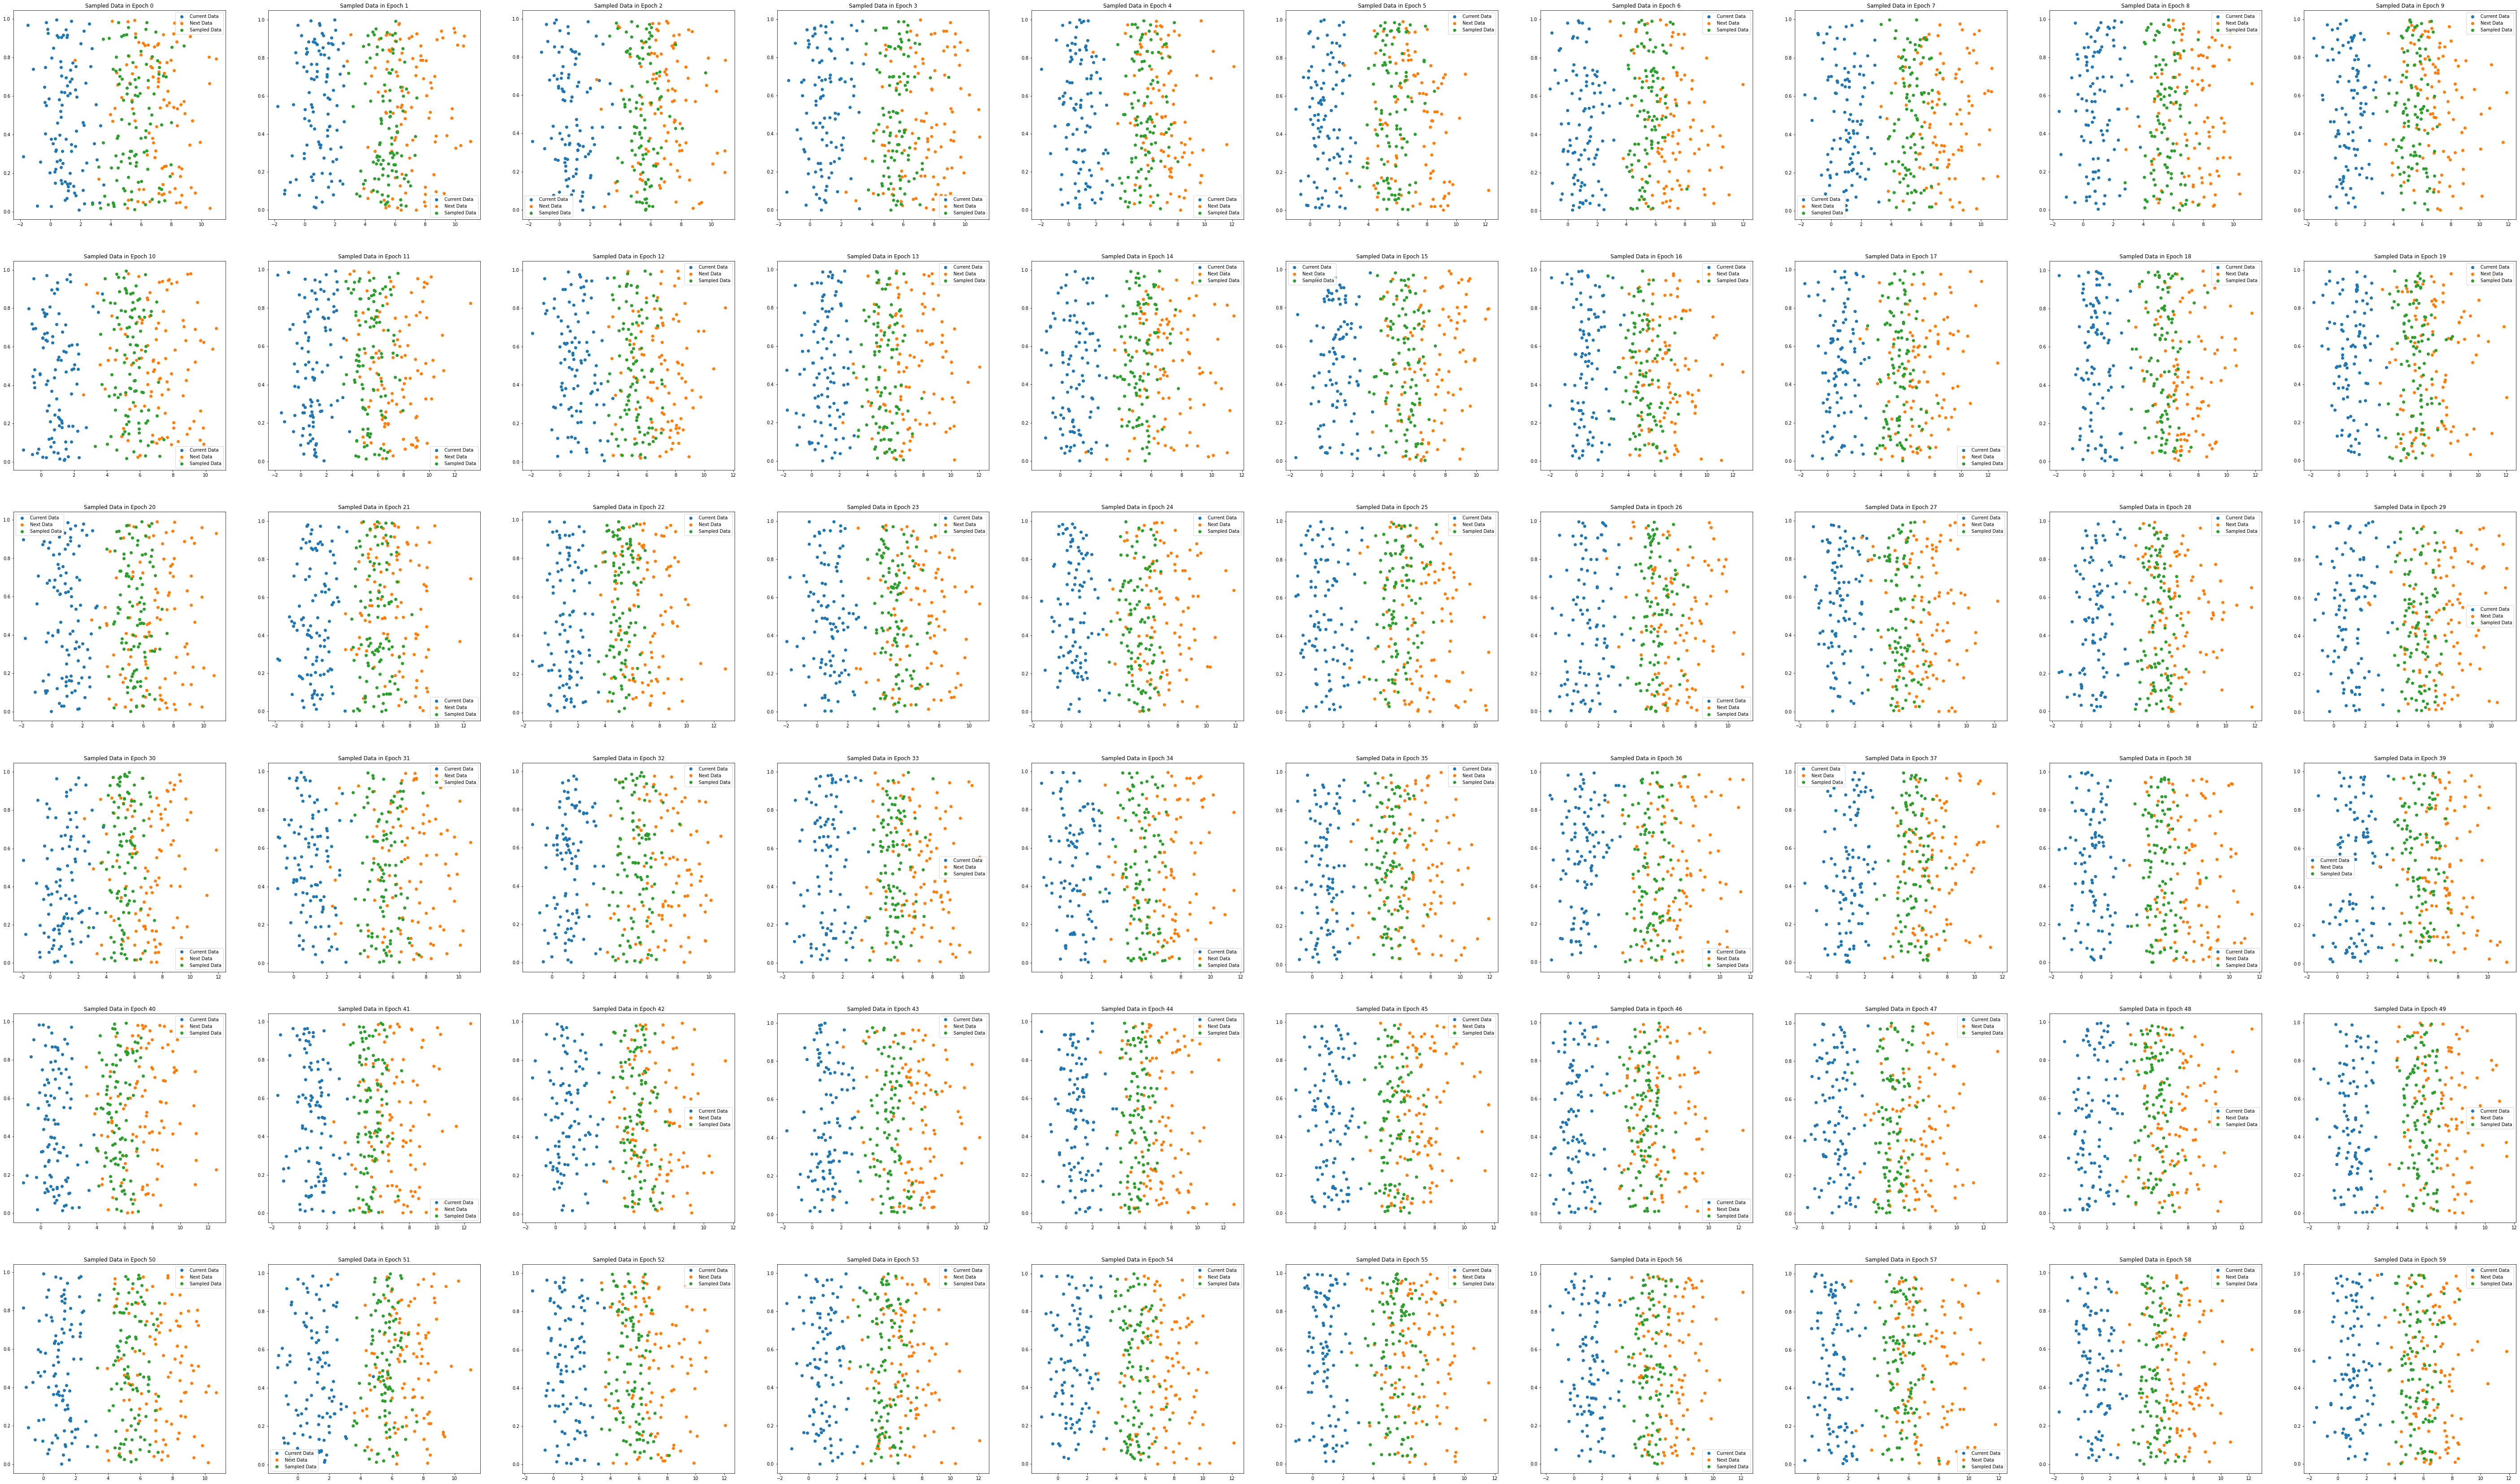

In [76]:
total_losses = []
diff_losses = []
mse_losses = [] # Losses bw sampled next state and actual next state

ncols = 10
nrows = math.ceil(EPOCHS / 10)
fig, axs = plt.subplots(figsize=(10*ncols, 10*nrows), nrows=nrows, ncols=ncols)
pbar = tqdm(total=EPOCHS)
# loss_epsilon = 

for i in range(EPOCHS):
    axs_row = int(i / ncols)
    axs_col = int(i % ncols)

    epoch_total_loss = 0
    # epoch_diff_loss = 0
    # epoch_mse_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        x0, xnext0, a = [b.to(device) for b in batch]
        loss = diffusion.loss(x0, a)
        # diff_loss, mse_loss = diffusion.next_state_loss(x0, xnext0)
        # mse_loss /= 10 # Scale the loss
        # print('diff_loss: {}, mse_loss: {}'.format(diff_loss, mse_loss))
        # TODO: Make sure the losses are scaled equaly
        # TODO: How does the model react when we forward prop 1000 times and then backprop?
        # TODO: Move this training to a script so that it can run forever

        # loss.backward() # Will train the eps_model
        # total_loss = diff_loss + mse_loss
        total_loss = loss # TODO: Check this out 
        total_loss.backward()
        optimizer.step()
        # epoch_diff_loss += diff_loss.item()
        # epoch_mse_loss += mse_loss.item()
        epoch_total_loss += total_loss.item()
    
    avg_loss = epoch_total_loss/len(mock_dset)
    total_losses.append(avg_loss)
    # diff_losses.append(epoch_diff_loss/len(mock_dset))
    # mse_losses.append(epoch_mse_loss/len(mock_dset))
    # print('epoch mse_loss: {}'.format(epoch_mse_loss/len(mock_dset)))
    # print('epoch diff_loss: {}'.format(epoch_diff_loss/len(mock_dset)))

    pbar.update(1)
    # pbar.set_description(f'Epoch: {i}, Loss: {avg_loss}, (MSE: {epoch_mse_loss/len(mock_dset)}, DIFF: {epoch_diff_loss/len(mock_dset)})')
    pbar.set_description(f'Epoch: {i}, Loss: {avg_loss}')

    # Sample 1k data from learned distribution - it should get closer and closer to the curr_z distribution
    # Get a random noise
    x = torch.randn((N_SAMPLES, 1), device=device)
    a = torch.normal(mean=x.new_full((N_SAMPLES,), action_mean),
                     std=x.new_full((N_SAMPLES,), action_std))
    for t_ in range(N_STEPS): # t_ indicates the diffusion step
        t = N_STEPS - t_ - 1
        x = diffusion.p_sample(x, x.new_full((N_SAMPLES,), t, dtype=torch.long), a)

    # print('curr_z_dset.data.shape: {}'.format(curr_z_dset.data.shape))
    # print('x.shape: {}'.format(x.shape))
    axs[axs_row, axs_col].set_title("Sampled Data in Epoch {}".format(i))
    plot_data(mock_dset.sample(is_curr=True, sample_size=N_SAMPLES), axs[axs_row, axs_col], label='Current Data') 
    plot_data(mock_dset.sample(is_curr=False, sample_size=N_SAMPLES), axs[axs_row, axs_col], label='Next Data')
    plot_data(x[:,0].cpu().detach().numpy(), axs[axs_row, axs_col], label='Sampled Data')


pbar.close() 

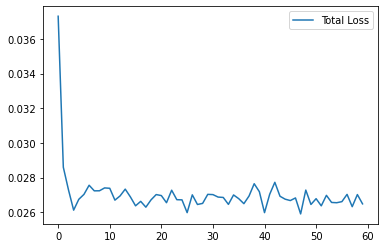

In [77]:
plt.plot(total_losses, label="Total Loss")
# plt.plot(mse_losses, label="MSE Loss")
# plt.plot(diff_losses, label="Diffusion Loss")
plt.legend()

NameError: name 'curr_z_dset' is not defined

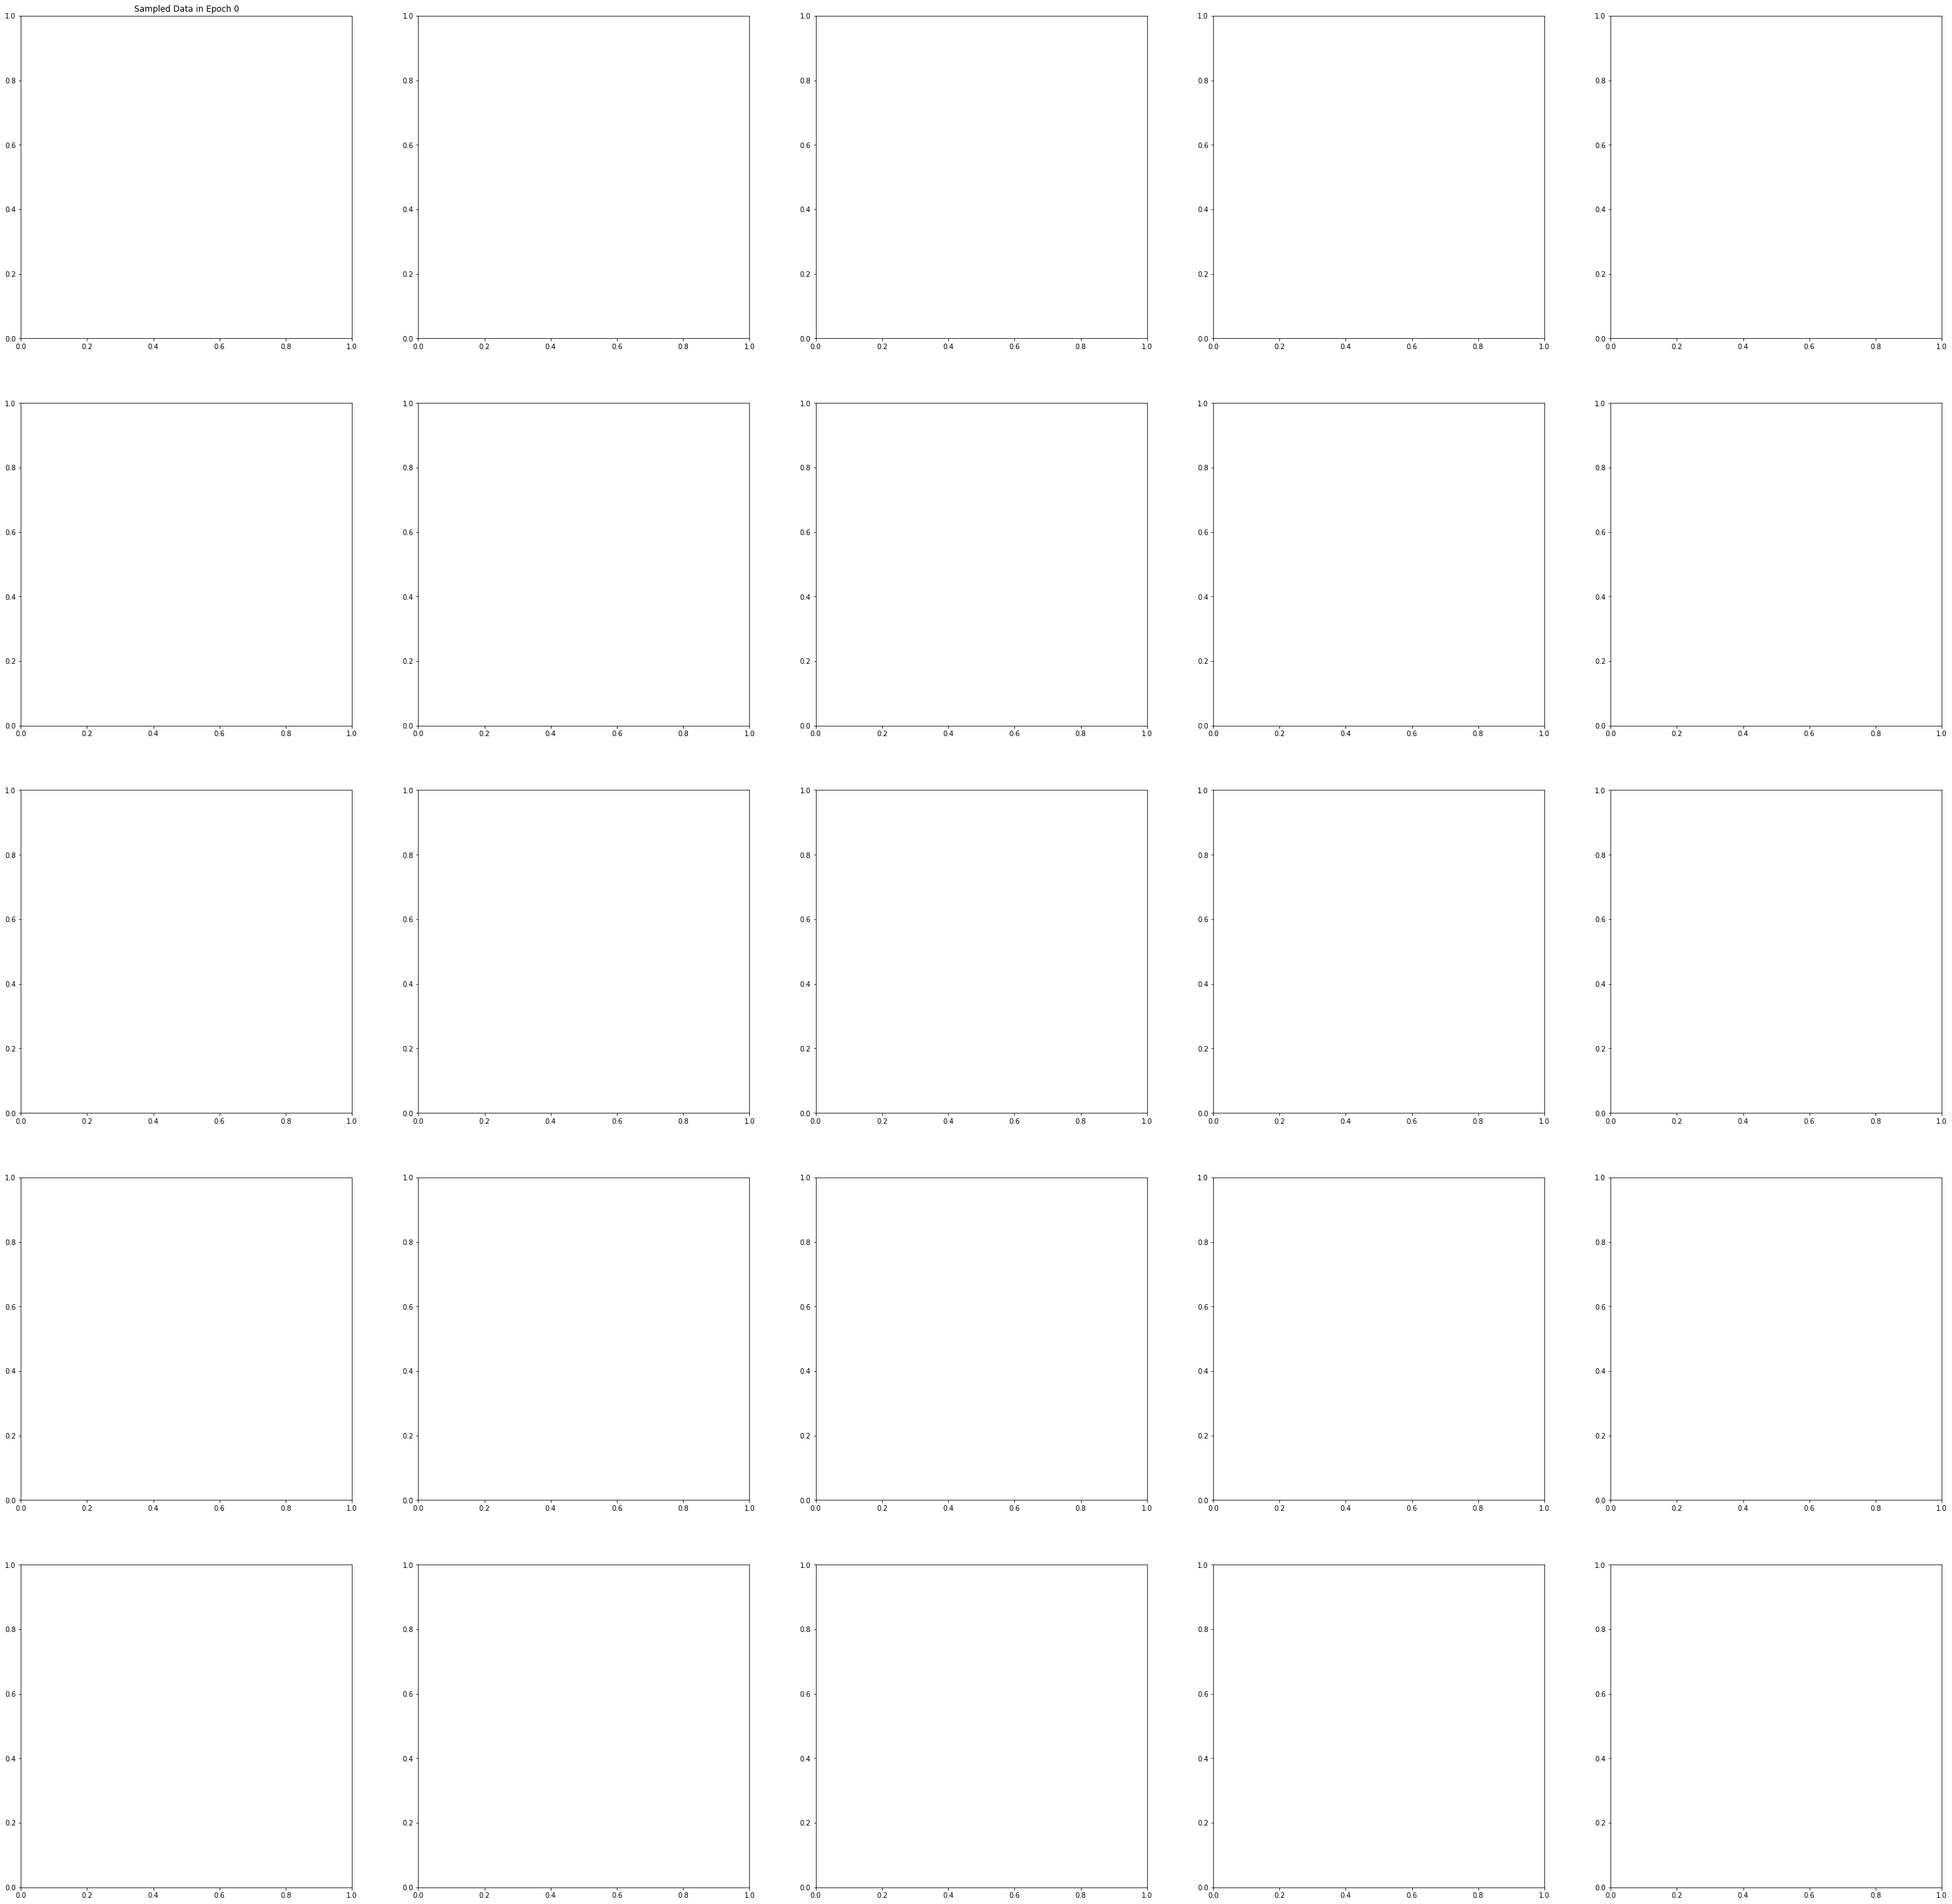

In [13]:
ncols = 5
nrows = 5
fig, axs = plt.subplots(figsize=(10*ncols, 10*nrows), nrows=nrows, ncols=ncols)
for i in range(25):
    axs_row = int(i / ncols)
    axs_col = int(i % ncols)
    
    x = torch.randn((N_SAMPLES, 1), device=device)
    for t_ in range(N_STEPS):
        t = N_STEPS - t_ - 1
        x = diffusion.p_sample(x, x.new_full((N_SAMPLES,), t, dtype=torch.long))

    # print('curr_z_dset.data.shape: {}'.format(curr_z_dset.data.shape))
    # print('x.shape: {}'.format(x.shape))
    axs[axs_row, axs_col].set_title("Sampled Data in Epoch {}".format(i))
    plot_gaus_dist(curr_z_dset.data, axs[axs_row, axs_col], label='Current Data') 
    plot_gaus_dist(x[:,0].cpu().detach().numpy(), axs[axs_row, axs_col], label='Sampled Data')

In [32]:
print(mse_losses)

[0.045794509065151215, 0.043318721276521685, 0.042252529764175414, 0.04156940042972565, 0.041601199287176135, 0.04074402250647545, 0.040281410437822344, 0.04016999319195747, 0.03997598230242729, 0.03898162867426872, 0.03980024564266205, 0.03896959664821625, 0.03848151451349258, 0.0390327218413353, 0.037606173676252366, 0.037444943588972095, 0.03753278525471687, 0.03775609790682793, 0.0371362165749073, 0.036985950535535814, 0.03703598525524139, 0.03733525884747505, 0.037044705849885944, 0.03795072974562645, 0.03711230778098106, 0.03689301489591598, 0.036484950113296506, 0.03639267107248306, 0.03591248171925545, 0.03600210883617401, 0.036558494532108306, 0.036914019429683684, 0.036176529997587206, 0.03626537251472473, 0.036327753150463105, 0.036015863442420956, 0.03691204950213432, 0.03639067497253418, 0.03642649902105331, 0.035872403091192245, 0.03574456369876861, 0.03608521767854691, 0.036175602543354037, 0.036036881011724475, 0.036253645288944245, 0.036233913749456406, 0.0362921583414

In [33]:
print(diff_losses)

[0.05121404400467872, 0.03662971980571747, 0.034912614715099335, 0.03387171140909195, 0.0341851442694664, 0.034193782857060435, 0.0346800097078085, 0.0342750365704298, 0.03448940940499306, 0.034823916697502136, 0.034134182810783384, 0.034607190892100334, 0.03495837180316448, 0.03468065606951713, 0.03536120535731316, 0.035826748526096346, 0.03600671575665474, 0.03522304284572601, 0.03620535028576851, 0.03593420851528645, 0.03638986615538597, 0.03611688778400421, 0.036259815573692324, 0.03556509483158588, 0.036445292389392855, 0.03634694625735283, 0.03665120084881782, 0.03659739369153976, 0.03637129130959511, 0.037163685977458956, 0.036686300984025, 0.036397213912010194, 0.036659256619215014, 0.03656919194459915, 0.03688853240013123, 0.036989785236120225, 0.03678574202060699, 0.03666317704916, 0.03710533246397972, 0.03656828436255455, 0.03696360815167427, 0.036360460442304614, 0.03687842405736447, 0.03656758540868759, 0.03698229124844074, 0.0366480084836483, 0.036583359563350674, 0.03670

Epoch: 49, Loss: 0.0032359053287655116, (MSE: 0.0032359053287655116, DIFF: 47.90936607055664): 100%|██████████| 50/50 [15:03<00:00, 18.08s/it] 


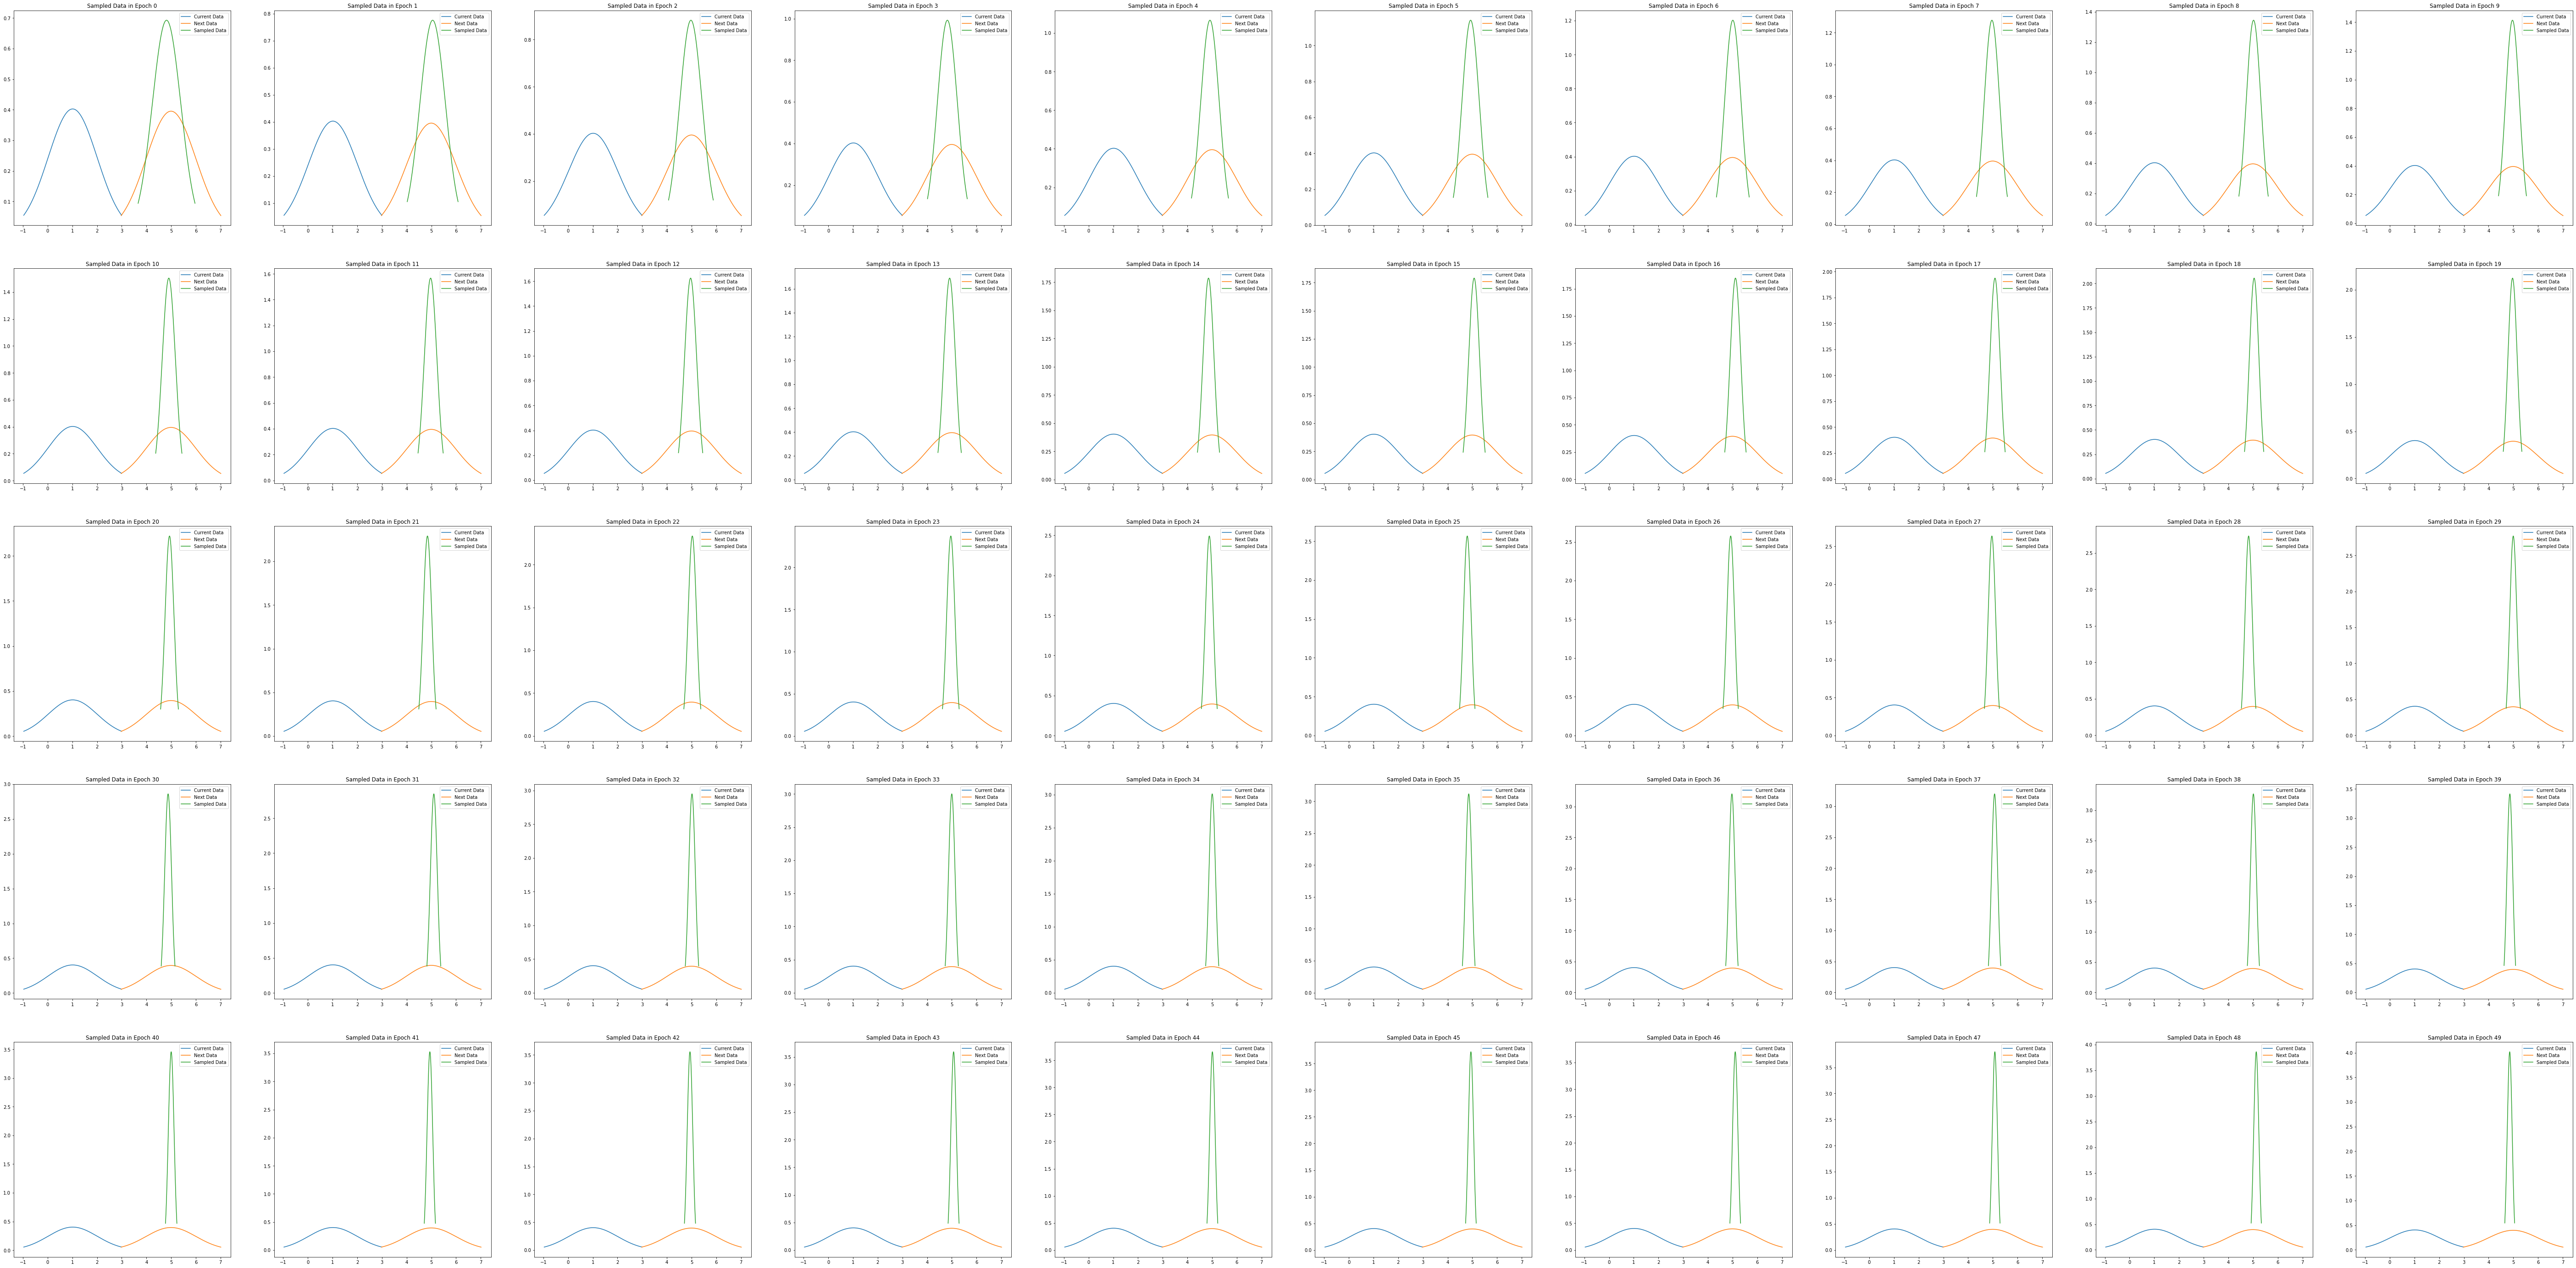

In [35]:
ncols = 10
nrows = math.ceil(EPOCHS / 10)
fig, axs = plt.subplots(figsize=(10*ncols, 10*nrows), nrows=nrows, ncols=ncols)
pbar = tqdm(total=EPOCHS)

for i in range(EPOCHS):
    axs_row = int(i / ncols)
    axs_col = int(i % ncols)

    epoch_total_loss = 0
    epoch_diff_loss = 0
    epoch_mse_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        x0, xnext0 = [b.to(device) for b in batch]
        # loss = diffusion.loss(x)
        diff_loss, mse_loss = diffusion.next_state_loss(x0, xnext0)
        mse_loss /= 10 # Scale the loss
        # print('diff_loss: {}, mse_loss: {}'.format(diff_loss, mse_loss))
        # TODO: Make sure the losses are scaled equaly
        # TODO: How does the model react when we forward prop 1000 times and then backprop?
        # TODO: Move this training to a script so that it can run forever

        # loss.backward() # Will train the eps_model
        total_loss = mse_loss
        total_loss.backward()
        optimizer.step()
        epoch_diff_loss += diff_loss.item()
        epoch_mse_loss += mse_loss.item()
        epoch_total_loss += total_loss.item()
    
    avg_loss = epoch_total_loss/len(mock_dset)
    total_losses.append(avg_loss)
    diff_losses.append(epoch_diff_loss/len(mock_dset))
    mse_losses.append(epoch_mse_loss/len(mock_dset))
    # print('epoch mse_loss: {}'.format(epoch_mse_loss/len(mock_dset)))
    # print('epoch diff_loss: {}'.format(epoch_diff_loss/len(mock_dset)))

    pbar.update(1)
    pbar.set_description(f'Epoch: {i}, Loss: {avg_loss}, (MSE: {epoch_mse_loss/len(mock_dset)}, DIFF: {epoch_diff_loss/len(mock_dset)})')

    # Sample 1k data from learned distribution - it should get closer and closer to the curr_z distribution
    # Get a random noise
    x = torch.randn((N_SAMPLES, 1), device=device)
    for t_ in range(N_STEPS):
        t = N_STEPS - t_ - 1
        x = diffusion.p_sample(x, x.new_full((N_SAMPLES,), t, dtype=torch.long))

    # print('curr_z_dset.data.shape: {}'.format(curr_z_dset.data.shape))
    # print('x.shape: {}'.format(x.shape))
    axs[axs_row, axs_col].set_title("Sampled Data in Epoch {}".format(i))
    plot_gaus_dist(mock_dset.curr_data, axs[axs_row, axs_col], label='Current Data') 
    plot_gaus_dist(mock_dset.next_data, axs[axs_row, axs_col], label='Next Data')
    plot_gaus_dist(x[:,0].cpu().detach().numpy(), axs[axs_row, axs_col], label='Sampled Data')


pbar.close() 